In [ ]:
# import from skimage
from skimage.color import rgb2gray
from skimage.filters import sobel, sobel_h, sobel_v, prewitt, roberts, gaussian
from skimage.feature import canny
import skimage.io as io

# import from matplotlib
import matplotlib.pyplot as plt

# import from numpy
import numpy as np

# import utils
from utils.commonfunctions import *


In [3]:
img = io.imread("datasets/dataset4_module1//1.jpg")
grey_scale = rgb2gray(img)

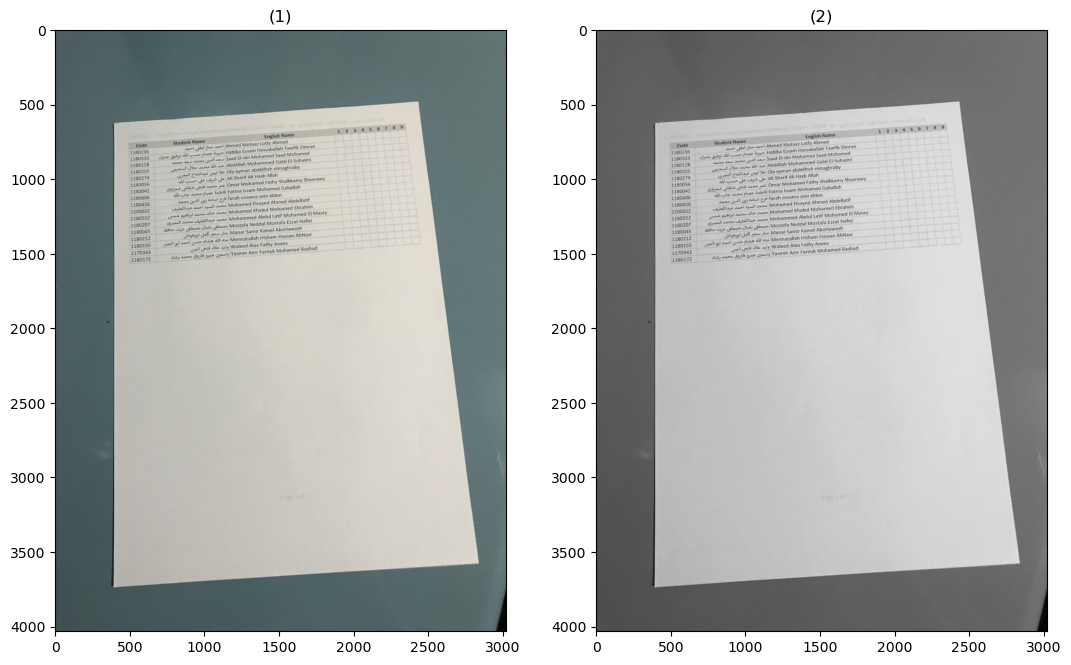

In [4]:
show_images(images=[img,grey_scale])